# TODO: Write theory here... 

(-1.0, 8.0)

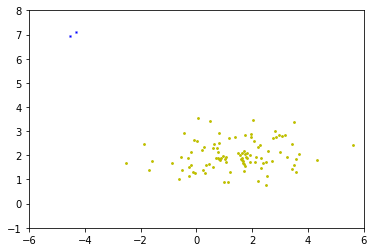

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Generate data from one Gaussian distribution.
N = 100;
data_mu = [1, 2];
data_sig = [[2, 0], [0, 0.5]];
X = np.random.multivariate_normal(data_mu, data_sig, N)

# Generate few outliers.
N_outliers = 2;
outliers_mu = [-4, 7];
outliers_sig = [[0.2, 0], [0, 0.2]];
outliers = np.random.multivariate_normal(outliers_mu, outliers_sig, N_outliers);
x_plus_outliers = np.concatenate((X, outliers), axis=0);


plt.plot(outliers[:, 0], outliers[:, 1], 'bx', markersize = 1.8)
plt.plot(X[:, 0], X[:, 1], 'yo', markersize = 1.8)
plt.xlim(-6,6)
plt.ylim(-1,8)

In [10]:
from scipy import stats

def fit_mog(X, K, precision):
    lamda = np.ones((K, 1), dtype=float) / K

    # Initialize the values in mu to K randomly chosen unique datapoints.
    mu = np.random.permutation(X)[0:K,:]

    # Initialize the variances in sig to the variance of the dataset.
    sig = []
    I, dimensionality = X.shape
    dataset_mean = np.sum(X, axis=0) / I
    dataset_variance = np.zeros((dimensionality, dimensionality), dtype=float)
    for i in range(I):
        mat = (X[i,:] - dataset_mean)[np.newaxis]
        mat = mat.T @ mat
        dataset_variance = dataset_variance + mat

    dataset_variance = dataset_variance / I
        
    for i in range(K):
        sig.append(dataset_variance)
    
    # The main loop.
    iterations = 0
    previous_L = 1000000 #Just a random initialization
    
    while True:
        # Expectation step.
        l = np.zeros((I, K))
        r = np.zeros((I, K))
        
        # Compute the numerator of Bayes' rule.
        for k in range (K):
            l[:,k] = lamda[k] * stats.multivariate_normal.pdf(X, mu[k,:], sig[k])
            
        s = np.sum(l, axis=1)
        for i in range(I):
            r[i,:] = l[i,:] / s[i]
        # Maximization step.
        r_summed_rows = np.sum(r,axis=0)
        r_summed_all = np.sum(np.sum(r,axis=0), axis=0)
        for k in range(K):
            
            # Update lambda.
            lamda[k] = r_summed_rows[k] / r_summed_all       

            # Update mu
            new_mu = np.zeros((1,dimensionality), dtype=float)
            for i in range(I):
                new_mu = new_mu + r[i,k]*X[i,:]
                
            mu[k,:] = new_mu / r_summed_rows[k]
            # Update sigma.
            new_sigma = np.zeros((dimensionality,dimensionality), dtype=float)
            for i in range(I):
                mat = (X[i,:] - mu[k,:])[np.newaxis]
                mat = r[i,k] * mat.T @ mat
                new_sigma = new_sigma + mat                
            sig[k] = new_sigma / r_summed_rows[k]
        # Compute the log likelihood L.
        temp = np.zeros((I,K), dtype=float)
        
        for k in range(K):
            temp[:, k] = lamda[k] * stats.multivariate_normal.pdf(X, mu[k,:], sig[k])

        temp = np.sum(temp, axis=1)
        temp = np.log(temp)        
        L = np.sum(temp, axis=0)  
        iterations = iterations + 1
        if (abs(L - previous_L) < precision):
            break
        previous_L = L
    return lamda, mu, sig
lamda2, mu2, sig2 = fit_mog(X, 2, 0.02)
# Fit a Gaussian to the original data and to the data with outliers.
lamda1, mu1, sig1 = fit_mog (X, 1, 0.01)
lamda2, mu2, sig2 = fit_mog (x_plus_outliers, 1, 0.01)

In [11]:
def prepare_mog_model(lamda, mu, sig, n):
    # Compute the first Gaussian as a matrix.
    mog = 0
    K, _ = mu.shape
    for index in range(K):
        # Now combine the two Gaussians with the corresponding weights in lambda,
        # to obtain the final mixture of Gaussians.
        temp = stats.multivariate_normal.pdf(x_y_matrix, mu[index,:], sig[index])
        gaussian = temp.reshape(n, n)
        mog += lamda[index]*gaussian
    return mog

(-1.0, 9.0)

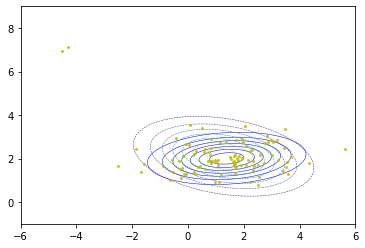

In [12]:
X_1_vals = np.arange(-10, 10, 0.01)
X_2_vals = np.arange(-10, 10, 0.01)
XX, YY = np.meshgrid(X_1_vals, X_2_vals)
size_ = XX.size
x = XX.reshape(size_,1)
y = YY.reshape(size_,1)
x_y_matrix = np.hstack((x,y))
n = len(XX)

mog1 = prepare_mog_model(lamda1, mu1, sig1, n)
mog2 = prepare_mog_model(lamda2, mu2, sig2, n)

# Create the contour plot.
plt.plot(x_plus_outliers[:, 0], x_plus_outliers[:, 1], 'yo', markersize = 2, alpha = .8)
plt.contour(XX,YY,mog1, colors=['b'], linewidths=0.5)
plt.contour(XX,YY,mog2, linestyles='dashed', corner_mask=False,linewidths=0.5, nchunk=0)
plt.xlim(-6,6)
plt.ylim(-1,9)


In [13]:
from scipy.special import gammaln
# The cost function to be minimized for nu.
def fit_t_cost (nu, E_hi, E_log_hi) -> float:
    nu_half = nu / 2
    I, _ = E_hi.shape
    val = I * (nu_half * np.log(nu_half) + gammaln(nu_half))
    val = val - (nu_half-1)*np.sum(E_log_hi)
    val = val + nu_half*np.sum(E_hi)
    val = -1 * val # the minus in front of the main sum
    return val

In [14]:
import math

# Multivariate t-distribution pdf.
def pdf_tm (x, mu, sig, nu):
    D = mu.size
    # gammaln is used instead of gamma to avoid overflow.
    # gamma((nu+D)/2)/gamma(nu/2) == exp(gammaln((nu+D)/2)-gammaln(nu/2)).
    c = math.exp(gammaln((nu+D)/2) - gammaln(nu/2))
    c = c / ((nu*math.pi) ** (D/2) * math.sqrt(np.linalg.det(sig)))

    I, _ = x.shape
    delta = np.zeros((I,1))
    x_minus_mu = x - mu
    temp = x_minus_mu @ np.linalg.inv(sig)
    for i in range(I):
        delta[i] = temp[i,:] @ x_minus_mu[i,:].T
    
    px = 1 + (delta / nu);
    px = np.power(px, (-nu-D)/2)
    px = px * c;

    return px

In [15]:
import scipy

def fit_t(X, precision):
    I, D = X.shape
    # Initialize mu to the mean of the dataset.
    dataset_mean = np.sum(X, axis=0) / I
    mu = dataset_mean
    # Initialize sig to the covariance of the dataset.
    dataset_variance = np.zeros((D, D))
    x_minus_dataset_mean = X - dataset_mean
    for i in range(I):
        mat = (x_minus_dataset_mean[i,:])[np.newaxis]
        mat = mat.T @ mat
        dataset_variance = dataset_variance + mat
    dataset_variance = dataset_variance / I
    sig = dataset_variance
    
    # Initialize degrees of freedom to 1000 (just a random large value).
    nu = 1000
    
    # The main loop.
    iterations = 0
    previous_L = 1000000 # just a random initialization
    delta = np.zeros((I,1))
    
    while True:
        # Expectation step.
        # Compute delta.
        x_minus_mu = X - mu
        temp = x_minus_mu @ np.linalg.inv(sig)
        for i in range(I):
            delta[i] = temp[i,:] @ x_minus_mu[i,:].T
        
        # Compute E_hi.
        nu_plus_delta = nu + delta
        E_hi = (nu + D) / nu_plus_delta
        
        # Compute E_log_hi.
        E_log_hi = scipy.special.digamma((nu+D)/2) - np.log(nu_plus_delta/2)
        
        # Maximization step.
        # Update mu.
        E_hi_sum = np.sum(E_hi, axis=0)
        E_hi_times_xi = E_hi * X
        mu = np.sum (E_hi_times_xi, axis=0) / E_hi_sum
        
        #Update sigma
        x_minus_mu = X - mu
        sig = np.zeros((D, D))
        for i in range(I):
            xmm = x_minus_mu[i, :][np.newaxis]
            sig = sig + E_hi[i] * xmm.T @ xmm
        sig = sig / E_hi_sum;

        # Update nu by minimizing a cost function with line search.
        nu = scipy.optimize.fminbound(fit_t_cost, 0, 1000, args=(E_hi, E_log_hi))
        print(nu)

        # Compute delta again, because the parameters were updated.
        temp = x_minus_mu @ np.linalg.inv(sig)
        for i in range(I):
            delta[i] = temp[i,:] @ x_minus_mu[i,:].T;
        
        # Compute the log likelihood L.
        L = I * (gammaln((nu+D)/2) - (D/2)*np.log(nu*np.pi) - np.log(np.linalg.det(sig))/2 - gammaln(nu/2))
        s = np.sum(np.log(1 + delta/nu)) / 2
        L = L - (nu+D)*s;
        
        iterations = iterations + 1
        if abs(L - previous_L) < precision:
            break
        previous_L = L
    return mu, sig, nu


999.999970046681
999.999970046681


(-1.0, 9.0)

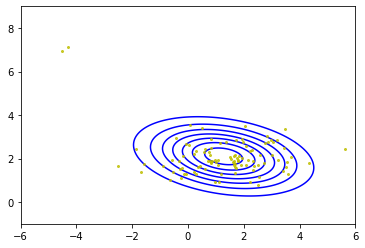

In [17]:
# Fit a t-distribution to the data with outliers.
t_mu, t_sig, t_nu = fit_t(x_plus_outliers, 0.01)

t_distribution = pdf_tm(x_y_matrix, t_mu, t_sig, t_nu)
t_distribution = t_distribution.reshape(n, n)

# Create the contour plot.
plt.plot(x_plus_outliers[:, 0], x_plus_outliers[:, 1], 'yo', markersize = 2, alpha = .8)
plt.contour(XX,YY,t_distribution, colors=['b'])
plt.xlim(-6,6)
plt.ylim(-1,9)
